In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.optim as optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
img = torchvision.io.read_image("/content/drive/My Drive/cyber-kitty.jpg")
img = torch.tensor(img, dtype=torch.float)

<ipython-input-8-6df8587dce73>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float)


In [9]:
# Function to calculate RMSE, PSNR metrics
def calculate_metrics(original, predicted):
    mse = nn.MSELoss()(original, predicted)
    rmse = torch.sqrt(mse)
    psnr = 20 * torch.log10(1 / rmse)
    return rmse.item(), psnr.item()

In [10]:
def normalize(img):
    return img / 255.0

def denormalize(img):
    return img * 255.0

Getting a 50x50 patch from the function as required in the question.

(-0.5, 49.5, 49.5, -0.5)

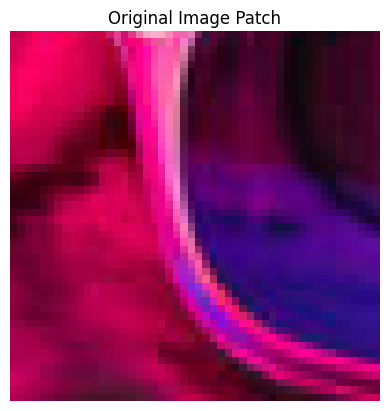

In [12]:
crop1 = torchvision.transforms.functional.crop(img, 150, 300, 50, 50)
crop1_ = crop1.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
plt.imshow(crop1_)
plt.title("Original Image Patch")
plt.axis('off')

In [13]:
def factorize(A, k, device=torch.device("cpu")):
    A = A.to(device)
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    for i in range(1000):
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return W, H, loss

In [14]:
def plot_images(original, reconstructions, ranks):
    num_reconstructions = len(reconstructions)

    rows = num_reconstructions
    fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 4), constrained_layout=True)
    fig.suptitle("Image Reconstruction", fontsize=22)

    for i, (reconstructed, r) in enumerate(zip(reconstructions, ranks)):
        axes[i, 0].imshow(original.permute(1, 2, 0).cpu().numpy().astype(np.uint8))
        axes[i, 0].set_title("Original Image", fontsize=16)
        axes[i, 0].axis('off')
        axes[i, 1].imshow(reconstructed.permute(1, 2, 0).cpu().numpy())
        axes[i, 1].set_title(f"Reconstructed Image (rank = {r})", fontsize=16)
        axes[i, 1].axis('off')
    for ax in axes.ravel():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    plt.subplots_adjust(hspace=0.3)
    plt.show()

Q. Compute the compressed patch by multiplying these two matrices and compare the reconstructed image patch with the original patch. Compute the Root Mean Squared Error (RMSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed image patches.


*   Test different values for the low-rank r=[5,10,25,50].
*   Use Gradient Descent to learn the compressed matrices.




In [22]:
reconstructions = []
ranks = []
r_r = []
p_r = []
img_p = []

for r in [5, 10, 25, 50]:
    W_red, H_red, loss_red = factorize(crop1[0], r)
    W_green, H_green, loss_green = factorize(crop1[1], r)
    W_blue, H_blue, loss_blue = factorize(crop1[2], r)
    red_reconstructed = torch.mm(W_red, H_red)
    green_reconstructed = torch.mm(W_green, H_green)
    blue_reconstructed = torch.mm(W_blue, H_blue)
    reconstructed_img = torch.stack([red_reconstructed, green_reconstructed, blue_reconstructed], dim=0)
    reconstructed_img = torch.clamp(reconstructed_img, 0, 255)
    reconstructed_img = reconstructed_img.to(torch.uint8)
    rmse_patch, psnr_patch = calculate_metrics(normalize(crop1), normalize(reconstructed_img))

    r_r.append(rmse_patch)
    p_r.append(psnr_patch)

    print("\nMatrix Rank =", r)
    print("The Peak signal to noise ratio is:", psnr_patch)
    print("The Root mean square error is:", rmse_patch)
    print()

    reconstructed_img = reconstructed_img.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    reconstructions.append(reconstructed_img)
    n_img = img.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    n_img[150:200, 300:350] = reconstructed_img
    reconstructed_img = n_img

    img_p.append(reconstructed_img)
    ranks.append(r)




Matrix Rank = 5
The Peak signal to noise ratio is: 20.791940689086914
The Root mean square error is: 0.09128575026988983


Matrix Rank = 10
The Peak signal to noise ratio is: 27.06857681274414
The Root mean square error is: 0.04431707784533501


Matrix Rank = 25
The Peak signal to noise ratio is: 47.22469711303711
The Root mean square error is: 0.004352764692157507


Matrix Rank = 50
The Peak signal to noise ratio is: 51.730628967285156
The Root mean square error is: 0.002591006690636277



Compute the RMSE and PSNR for each value of r.

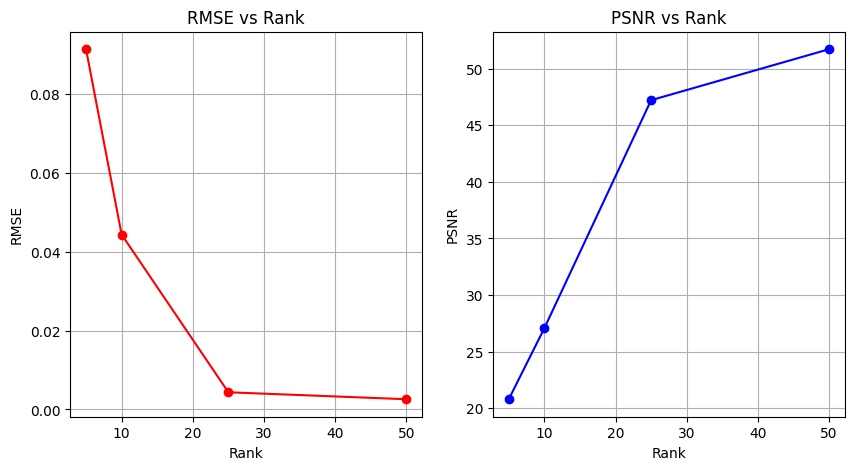

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(ranks, r_r, color = "red", marker = "o")
axes[0].set_title("RMSE vs Rank")
axes[0].set_xlabel("Rank")
axes[0].set_ylabel("RMSE")
axes[0].grid()

axes[1].plot(ranks, p_r, color = "blue", marker = "o")
axes[1].set_title("PSNR vs Rank")
axes[1].set_xlabel("Rank")
axes[1].set_ylabel("PSNR")
axes[1].grid()

Display the reconstructed image patches, keeping the original pixel values outside the patch unchanged, and use your compressed matrix for the patch to show how well the reconstruction works.

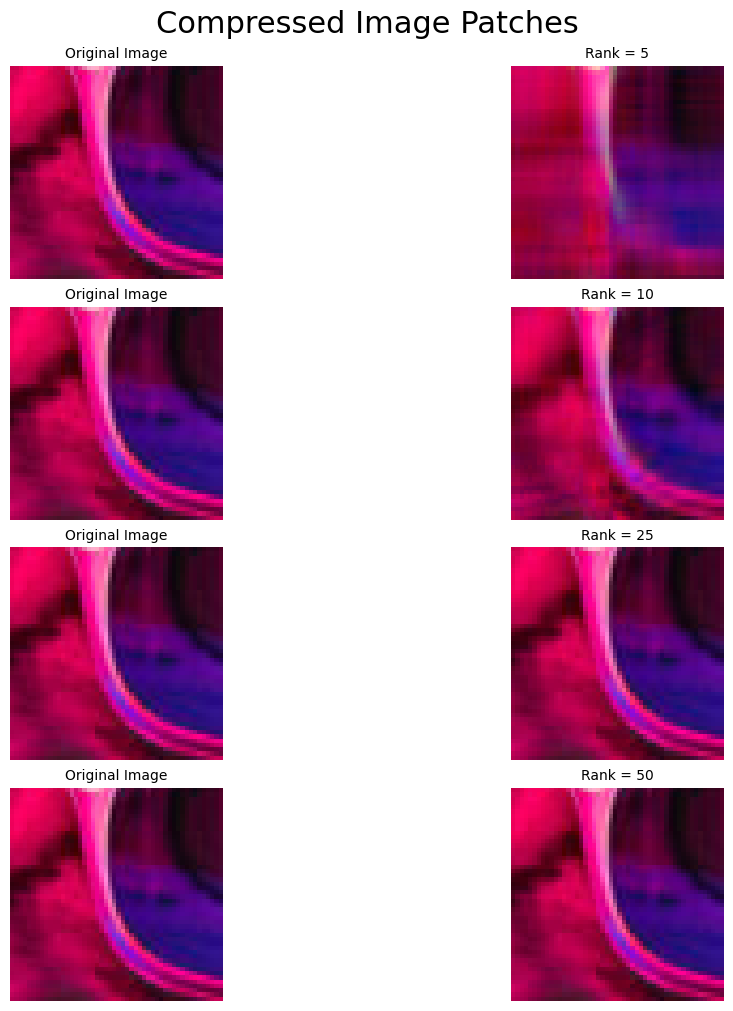

In [24]:
fig, axes = plt.subplots(4, 2, figsize=(10, 10), constrained_layout=True)
fig.suptitle("Compressed Image Patches", fontsize=22)

for i, (reconstructed, r) in enumerate(zip(reconstructions, ranks)):
    axes[i, 0].imshow(crop1_)
    axes[i, 0].set_title("Original Image", fontsize=10)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(reconstructed)
    axes[i, 1].set_title(f"Rank = {r}", fontsize=10)
    axes[i, 1].axis('off')

plt.show()

In [25]:
img = img.permute(1, 2, 0).cpu().numpy().astype(np.uint8)

<ipython-input-28-24536635c069>:19: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.3)


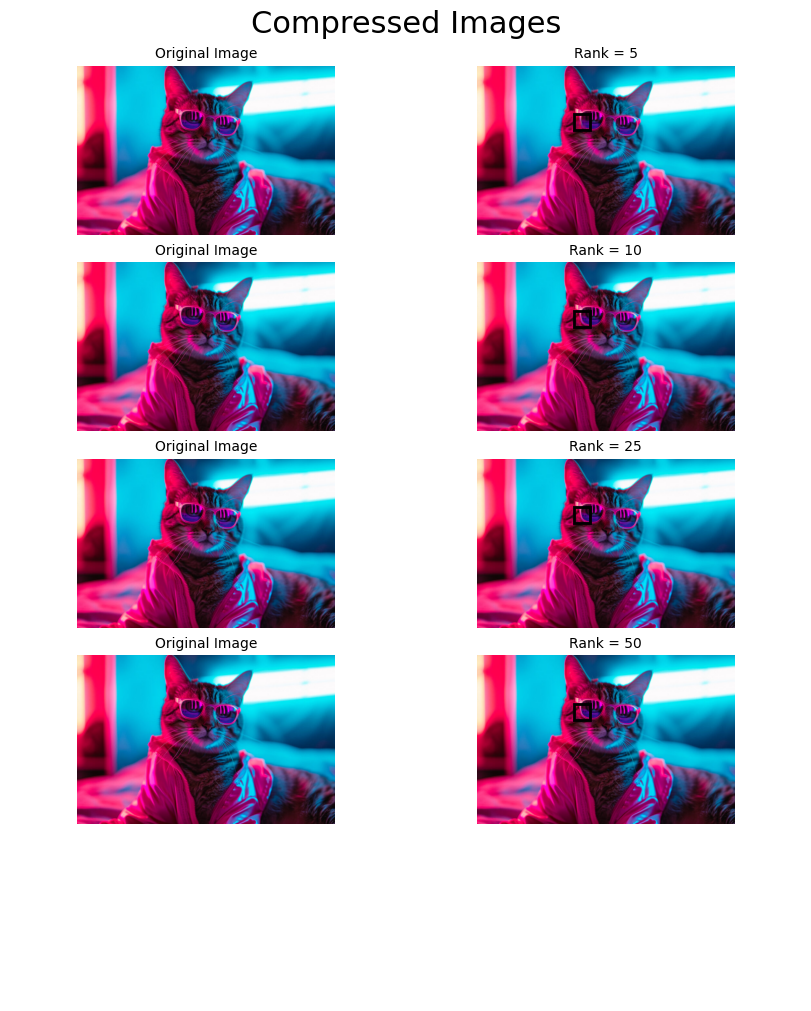

In [28]:

fig, axes = plt.subplots(5, 2, figsize=(8, 10), constrained_layout=True)
fig.suptitle("Compressed Images", fontsize=22)

for i, (imgp_, r) in enumerate(zip(img_p, ranks)):
    axes[i, 0].imshow(img)
    axes[i, 0].set_title("Original Image", fontsize=10)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(imgp_)
    axes[i, 1].add_patch(plt.Rectangle((300, 150), 50, 50, fill=False, edgecolor='black', lw=2))
    axes[i, 1].set_title(f"Rank = {r}", fontsize=10)
    axes[i, 1].axis('off')
for ax in axes.ravel():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0.3)
plt.show()